In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -q UCMerced_LandUse.zip -d ./UCMerced_LandUse


--2025-04-11 14:13:43--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  14.3MB/s    in 24s     

2025-04-11 14:14:07 (13.1 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [3]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Set the path to the dataset directory
DATA_DIR = "/content/UCMerced_LandUse/UCMerced_LandUse/Images"

# Set image size and batch size
IMAGE_SIZE = 224  # common input size for AlexNet, VGG19, ResNet50
BATCH_SIZE = 32
RANDOM_SEED = 42

# Define data transformations: Resize, Normalize, Augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load the dataset with ImageFolder
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transform)

# Split dataset into Train, Validation, and Test
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

torch.manual_seed(RANDOM_SEED)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Use separate transforms for validation and test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check class names
class_names = full_dataset.classes
print("Classes:", class_names)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Optional: Visualize some training images
def show_batch(loader):
    images, labels = next(iter(loader))
    grid_img = torchvision.utils.make_grid(images[:16], nrow=4, padding=2, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Training Images")
    plt.axis('off')
    plt.show()

# show_batch(train_loader)  # Uncomment to visualize


Classes: ['agricultural', 'airplane', 'baseballdiamond', 'beach', 'buildings', 'chaparral', 'denseresidential', 'forest', 'freeway', 'golfcourse', 'harbor', 'intersection', 'mediumresidential', 'mobilehomepark', 'overpass', 'parkinglot', 'river', 'runway', 'sparseresidential', 'storagetanks', 'tenniscourt']
Train: 1470, Val: 315, Test: 315


In [4]:
import torch
import torch.nn as nn
import torchvision.models as models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

NUM_CLASSES = 21  # UC Merced has 21 land use classes


Using device: cuda


In [5]:
def get_model(name):
    if name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)

    elif name == 'vgg19':
        model = models.vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)

    elif name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

    else:
        raise ValueError("Unknown model name")

    return model.to(device)


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{model.__class__.__name__}.pth")

    print("Best Validation Accuracy:", best_acc)


In [7]:
model = get_model('alexnet')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 181MB/s]


Epoch 1/10 - Loss: 55.2761 - Train Acc: 0.6347 - Val Acc: 0.8381
Epoch 2/10 - Loss: 11.8374 - Train Acc: 0.9129 - Val Acc: 0.8762
Epoch 3/10 - Loss: 4.5260 - Train Acc: 0.9701 - Val Acc: 0.8857
Epoch 4/10 - Loss: 2.5769 - Train Acc: 0.9823 - Val Acc: 0.8952
Epoch 5/10 - Loss: 1.9334 - Train Acc: 0.9864 - Val Acc: 0.9111
Epoch 6/10 - Loss: 2.5916 - Train Acc: 0.9830 - Val Acc: 0.9079
Epoch 7/10 - Loss: 1.2326 - Train Acc: 0.9932 - Val Acc: 0.9270
Epoch 8/10 - Loss: 1.5511 - Train Acc: 0.9898 - Val Acc: 0.8825
Epoch 9/10 - Loss: 2.2215 - Train Acc: 0.9857 - Val Acc: 0.9048
Epoch 10/10 - Loss: 1.8774 - Train Acc: 0.9878 - Val Acc: 0.9206
Best Validation Accuracy: 0.926984126984127


In [8]:
model = get_model('vgg19')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.8MB/s]


Epoch 1/10 - Loss: 69.9420 - Train Acc: 0.5252 - Val Acc: 0.8349
Epoch 2/10 - Loss: 23.2486 - Train Acc: 0.8313 - Val Acc: 0.8286
Epoch 3/10 - Loss: 12.9349 - Train Acc: 0.9102 - Val Acc: 0.9175
Epoch 4/10 - Loss: 9.1605 - Train Acc: 0.9401 - Val Acc: 0.8540
Epoch 5/10 - Loss: 10.7861 - Train Acc: 0.9347 - Val Acc: 0.8889
Epoch 6/10 - Loss: 4.1304 - Train Acc: 0.9762 - Val Acc: 0.9079
Epoch 7/10 - Loss: 3.2511 - Train Acc: 0.9816 - Val Acc: 0.9206
Epoch 8/10 - Loss: 2.1044 - Train Acc: 0.9837 - Val Acc: 0.8857
Epoch 9/10 - Loss: 5.7502 - Train Acc: 0.9646 - Val Acc: 0.8190
Epoch 10/10 - Loss: 4.7218 - Train Acc: 0.9667 - Val Acc: 0.9111
Best Validation Accuracy: 0.9206349206349206


In [9]:
model = get_model('resnet50')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 68.7MB/s]


Epoch 1/10 - Loss: 53.1094 - Train Acc: 0.7517 - Val Acc: 0.9397
Epoch 2/10 - Loss: 6.4446 - Train Acc: 0.9748 - Val Acc: 0.9587
Epoch 3/10 - Loss: 2.7971 - Train Acc: 0.9898 - Val Acc: 0.9841
Epoch 4/10 - Loss: 2.3656 - Train Acc: 0.9871 - Val Acc: 0.9714
Epoch 5/10 - Loss: 1.7938 - Train Acc: 0.9898 - Val Acc: 0.9746
Epoch 6/10 - Loss: 1.5250 - Train Acc: 0.9925 - Val Acc: 0.9778
Epoch 7/10 - Loss: 1.5294 - Train Acc: 0.9932 - Val Acc: 0.9778
Epoch 8/10 - Loss: 0.6167 - Train Acc: 1.0000 - Val Acc: 0.9873
Epoch 9/10 - Loss: 0.6427 - Train Acc: 0.9973 - Val Acc: 0.9810
Epoch 10/10 - Loss: 0.8911 - Train Acc: 0.9959 - Val Acc: 0.9619
Best Validation Accuracy: 0.9873015873015873


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from datetime import datetime
import os

# Create folder for logs and models
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 21
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-4

# Replace with your LeNet5 definition if needed
class LeNet5(nn.Module):
    def __init__(self, num_classes=21):
        super(LeNet5, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 53 * 53, 120),  # 224x224 -> 53x53 after pooling
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Load pretrained models
def get_model(name):
    if name == 'alexnet':
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
    elif name == 'vgg19':
        model = models.vgg19(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
    elif name == 'resnet50':
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    elif name == 'lenet5':
        model = LeNet5(NUM_CLASSES)
    else:
        raise ValueError(f"Unknown model name {name}")
    return model.to(device)

# Training loop
def train_and_evaluate(model_name, train_loader, val_loader, epochs=EPOCHS, lr=LR):
    print(f"\nTraining {model_name}...")

    model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = val_correct / val_total

        # Logging
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

        print(f"Epoch {epoch+1:02}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), f"models/best_{model_name}.pth")

    # Save log
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_path = f"logs/log_{model_name}_{timestamp}.txt"
    with open(log_path, 'w') as f:
        f.write(f"Model: {model_name}\nEpochs: {epochs}\nBatch Size: {BATCH_SIZE}\nLearning Rate: {lr}\n")
        f.write("Epoch,TrainLoss,TrainAcc,ValLoss,ValAcc\n")
        for i in range(epochs):
            f.write(f"{i+1},{train_losses[i]:.4f},{train_accs[i]:.4f},{val_losses[i]:.4f},{val_accs[i]:.4f}\n")

    print(f"Finished training {model_name}. Best Val Acc: {best_acc:.4f}. Log saved to {log_path}")

# Example: Train all 4 models
for model_name in ['lenet5', 'alexnet', 'vgg19', 'resnet50']:
    train_and_evaluate(model_name, train_loader, val_loader)



Training lenet5...
Epoch 01/10 | Train Loss: 2.8977 | Train Acc: 0.1497 | Val Loss: 2.7918 | Val Acc: 0.1873
Epoch 02/10 | Train Loss: 2.5945 | Train Acc: 0.3184 | Val Loss: 2.6916 | Val Acc: 0.2508
Epoch 03/10 | Train Loss: 2.4089 | Train Acc: 0.4041 | Val Loss: 2.6381 | Val Acc: 0.2508
Epoch 04/10 | Train Loss: 2.2214 | Train Acc: 0.5061 | Val Loss: 2.5819 | Val Acc: 0.2762
Epoch 05/10 | Train Loss: 2.0561 | Train Acc: 0.5823 | Val Loss: 2.5714 | Val Acc: 0.2730
Epoch 06/10 | Train Loss: 1.8820 | Train Acc: 0.6612 | Val Loss: 2.5356 | Val Acc: 0.2952
Epoch 07/10 | Train Loss: 1.7290 | Train Acc: 0.7204 | Val Loss: 2.5527 | Val Acc: 0.2825
Epoch 08/10 | Train Loss: 1.5620 | Train Acc: 0.7796 | Val Loss: 2.4967 | Val Acc: 0.3111
Epoch 09/10 | Train Loss: 1.3976 | Train Acc: 0.8320 | Val Loss: 2.4745 | Val Acc: 0.3302
Epoch 10/10 | Train Loss: 1.2421 | Train Acc: 0.8762 | Val Loss: 2.4923 | Val Acc: 0.2984
Finished training lenet5. Best Val Acc: 0.3302. Log saved to logs/log_lenet5_202

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

def test_model(model_name, test_loader):
    # Load the best model
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"models/best_{model_name}.pth"))
    model.eval()

    criterion = nn.CrossEntropyLoss()
    correct, total, test_loss = 0, 0, 0

    # Start timer for computational complexity
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    avg_test_loss = test_loss / len(test_loader)

    # Calculate total test time
    end_time = time.time()
    test_time = end_time - start_time

    print(f"Test Accuracy for {model_name}: {test_accuracy:.4f}")
    print(f"Test Loss for {model_name}: {avg_test_loss:.4f}")
    print(f"Test Time for {model_name}: {test_time:.4f} seconds")

    return test_accuracy, avg_test_loss, test_time


In [12]:
# Testing the models
test_results = {}
for model_name in ['lenet5', 'alexnet', 'vgg19', 'resnet50']:
    accuracy, loss, time_taken = test_model(model_name, test_loader)
    test_results[model_name] = {"accuracy": accuracy, "loss": loss, "time": time_taken}


Test Accuracy for lenet5: 0.3397
Test Loss for lenet5: 2.4420
Test Time for lenet5: 2.0417 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy for alexnet: 0.9238
Test Loss for alexnet: 0.2376
Test Time for alexnet: 1.1488 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy for vgg19: 0.9302
Test Loss for vgg19: 0.2337
Test Time for vgg19: 2.8002 seconds


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Test Accuracy for resnet50: 0.9683
Test Loss for resnet50: 0.1144
Test Time for resnet50: 1.6298 seconds


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_feature_maps(model_name, input_image):
    # Load model and set to eval mode
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"models/best_{model_name}.pth"))
    model.eval()

    # Define the layers to visualize
    layers_to_visualize = [model.features[0], model.features[3], model.features[6]]  # For AlexNet as an example
    if model_name == 'vgg19':
        layers_to_visualize = [model.features[0], model.features[5], model.features[10]]  # VGG19
    elif model_name == 'resnet50':
        layers_to_visualize = [model.conv1, model.layer1[0].conv1, model.layer2[0].conv1]  # ResNet50

    def hook_fn(module, input, output):
        feature_maps.append(output.detach())

    feature_maps = []
    hooks = []

    # Register hooks for each layer
    for layer in layers_to_visualize:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Pass a sample image through the model to get feature maps
    with torch.no_grad():
        input_image = input_image.unsqueeze(0).to(device)  # Adding batch dimension
        _ = model(input_image)

    # Visualize the feature maps
    fig, axes = plt.subplots(len(layers_to_visualize), 8, figsize=(15, 15))
    for i, ax in enumerate(axes):
        for j in range(min(feature_maps[i].shape[1], 8)):  # Display up to 8 feature maps
            ax[j].imshow(feature_maps[i][0, j].cpu().numpy(), cmap='viridis')
            ax[j].axis('off')
        plt.show()

    # Remove hooks after use
    for hook in hooks:
        hook.remove()


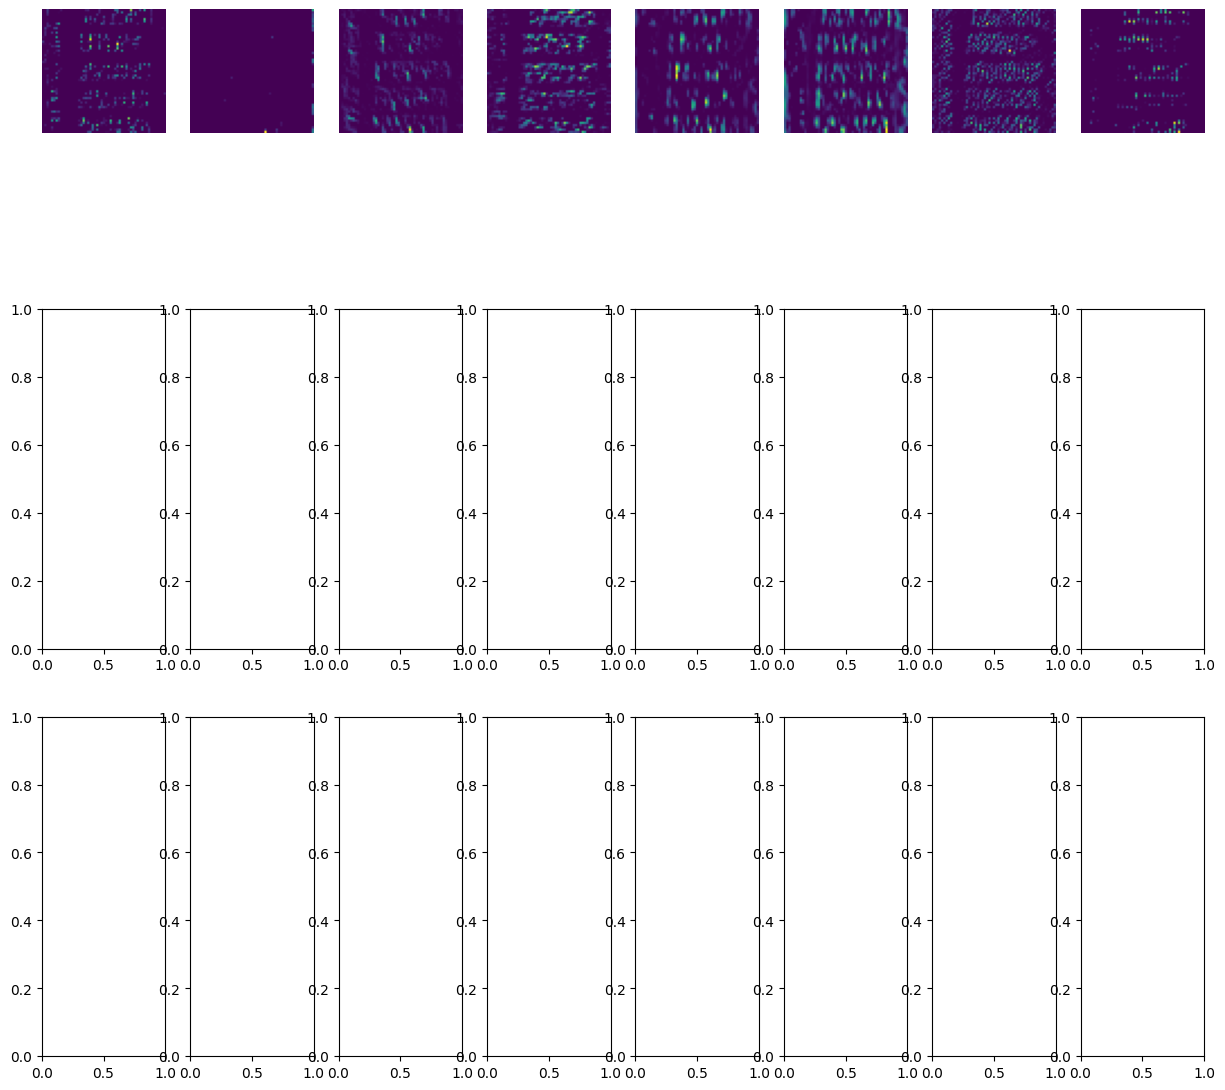

In [14]:
# Use a sample image from test_loader
sample_image, _ = next(iter(test_loader))
visualize_feature_maps('alexnet', sample_image[0])  # Example for AlexNet


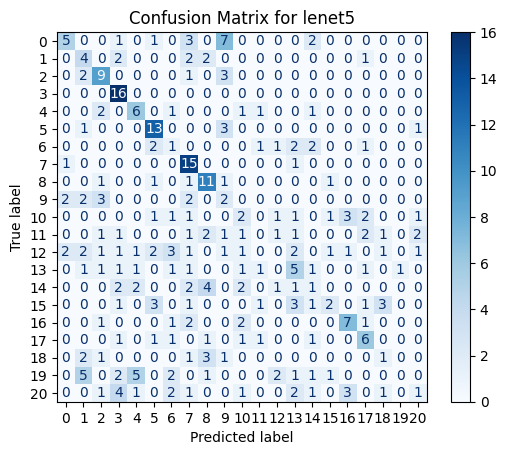

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


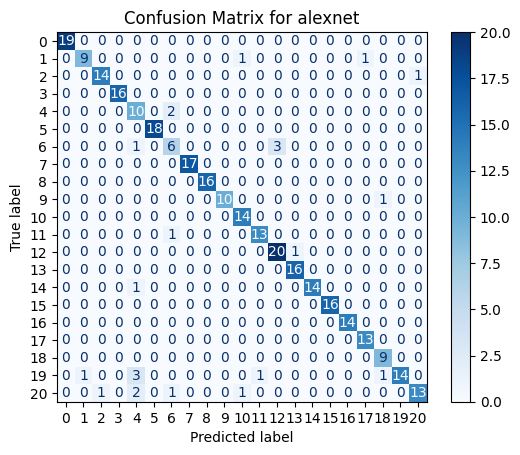

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


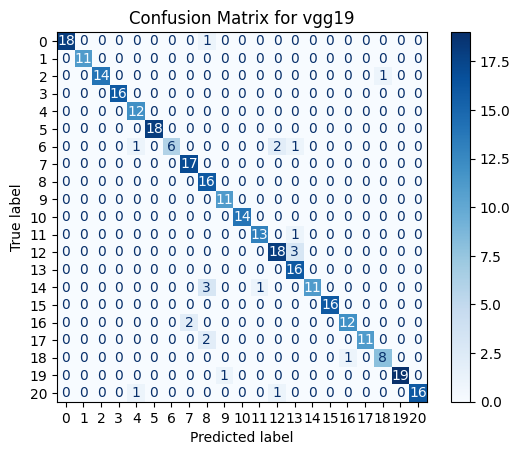

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


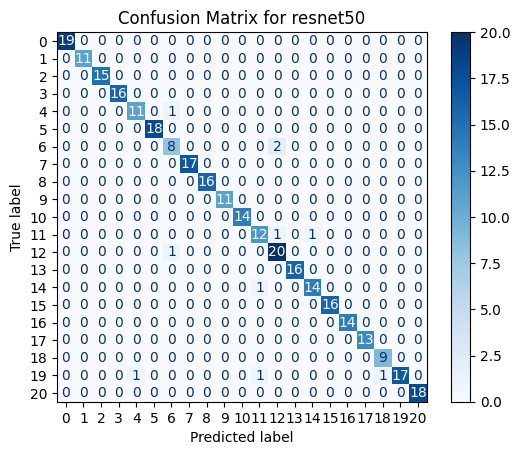

In [15]:
def plot_confusion_matrix(model_name, test_loader):
    # Load model
    model = get_model(model_name)
    model.load_state_dict(torch.load(f"models/best_{model_name}.pth"))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

# Plot confusion matrices for all models
for model_name in ['lenet5', 'alexnet', 'vgg19', 'resnet50']:
    plot_confusion_matrix(model_name, test_loader)


In [16]:
print("Test Results Comparison:")
for model_name, metrics in test_results.items():
    print(f"{model_name}:")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Test Time: {metrics['time']:.4f} seconds")


Test Results Comparison:
lenet5:
  Accuracy: 0.3397
  Loss: 2.4420
  Test Time: 2.0417 seconds
alexnet:
  Accuracy: 0.9238
  Loss: 0.2376
  Test Time: 1.1488 seconds
vgg19:
  Accuracy: 0.9302
  Loss: 0.2337
  Test Time: 2.8002 seconds
resnet50:
  Accuracy: 0.9683
  Loss: 0.1144
  Test Time: 1.6298 seconds


In [17]:
def plot_training_curves():
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for model_name in ['lenet5', 'alexnet', 'vgg19', 'resnet50']:
        log_path = f"logs/log_{model_name}_*.txt"
        # Load logs and plot
        # Add your logic for loading and plotting accuracy curves
        plt.plot(...)

    plt.title("Model Accuracy Comparison")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    for model_name in ['lenet5', 'alexnet', 'vgg19', 'resnet50']:
        # Add your logic for plotting loss curves
        plt.plot(...)

    plt.title("Model Loss Comparison")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [18]:
import matplotlib.pyplot as plt

def visualize_feature_maps(model_name, image_tensor):
    model = get_model(model_name).to(device)
    model.load_state_dict(torch.load(f"models/best_{model_name}.pth"))
    model.eval()

    # Define layers to hook based on model
    if model_name == 'alexnet':
        layers = [model.features[0], model.features[3], model.features[6]]
    elif model_name == 'vgg19':
        layers = [model.features[0], model.features[5], model.features[10]]
    elif model_name == 'resnet50':
        layers = [model.conv1, model.layer1[0].conv1, model.layer2[0].conv1]
    else:
        raise ValueError("Unsupported model for feature map visualization.")

    # Hook setup
    feature_maps = []
    def hook_fn(module, input, output):
        feature_maps.append(output)

    hooks = [layer.register_forward_hook(hook_fn) for layer in layers]

    # Run image through model
    with torch.no_grad():
        _ = model(image_tensor.unsqueeze(0).to(device))

    # Plot
    for i, fmap in enumerate(feature_maps):
        plt.figure(figsize=(12, 4))
        for j in range(min(6, fmap.shape[1])):
            plt.subplot(1, 6, j + 1)
            plt.imshow(fmap[0, j].cpu(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"{model_name.upper()} - Layer {i+1}")
        plt.show()

    for h in hooks:
        h.remove()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


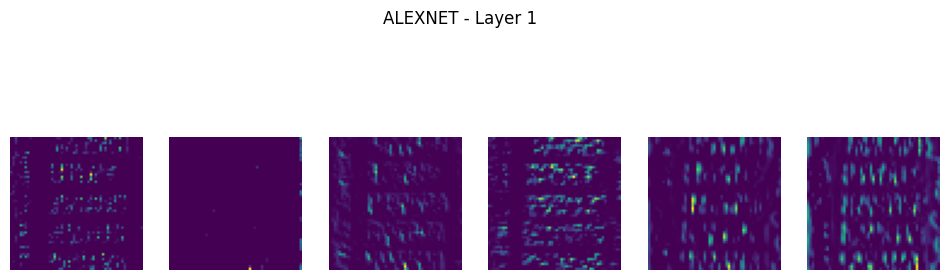

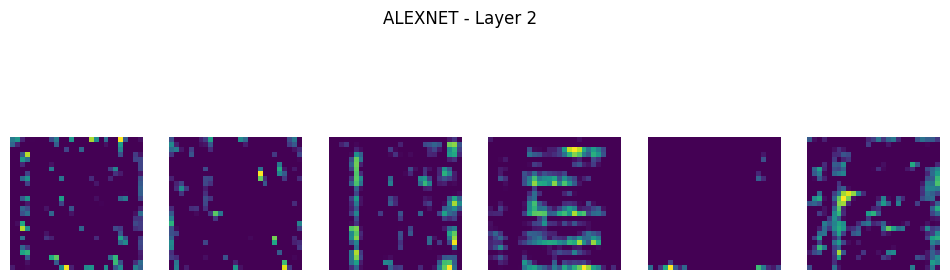

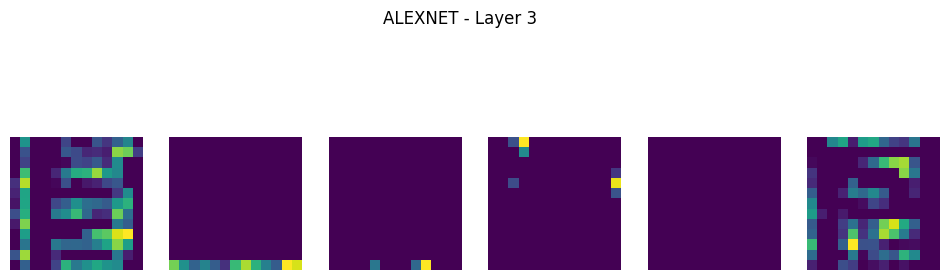

In [19]:
sample_image, _ = next(iter(test_loader))
visualize_feature_maps('alexnet', sample_image[0])


In [25]:
!pip install numpy==1.26.4


In [26]:
!pip install torchcam


In [32]:
import torch
import torchvision.models as models
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[0, class_idx].backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        return cam

    def __del__(self):
        for handle in self.hook_handles:
            handle.remove()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


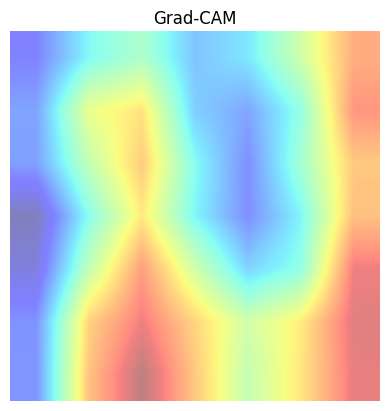

In [33]:
# Load model
model = models.resnet50(pretrained=True)
target_layer = model.layer4  # Last convolutional block

gradcam = GradCAM(model, target_layer)

# Dummy input
sample_image, _ = next(iter(test_loader))  # Shape: [B, C, H, W]
input_tensor = sample_image[0].unsqueeze(0)

# Generate CAM
cam = gradcam.generate(input_tensor)

# Show result
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("Grad-CAM")
plt.show()

In [34]:
def plot_training_curves(train_logs):
    """
    Expects train_logs to be a dictionary:
    {
        'model_name': {
            'train_loss': [...],
            'val_loss': [...],
            'train_acc': [...],
            'val_acc': [...]
        }, ...
    }
    """
    for metric in ['loss', 'acc']:
        plt.figure(figsize=(12, 5))
        for model_name, log in train_logs.items():
            if metric == 'loss':
                plt.plot(log['train_loss'], label=f'{model_name} - Train')
                plt.plot(log['val_loss'], linestyle='--', label=f'{model_name} - Val')
                plt.title("Loss Curves")
                plt.ylabel("Loss")
            else:
                plt.plot(log['train_acc'], label=f'{model_name} - Train')
                plt.plot(log['val_acc'], linestyle='--', label=f'{model_name} - Val')
                plt.title("Accuracy Curves")
                plt.ylabel("Accuracy")
        plt.xlabel("Epochs")
        plt.legend()
        plt.grid(True)
        plt.show()


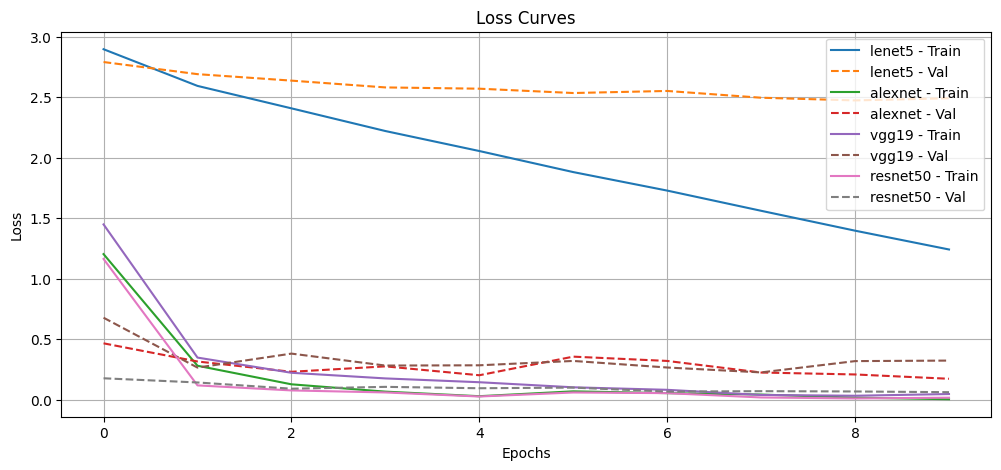

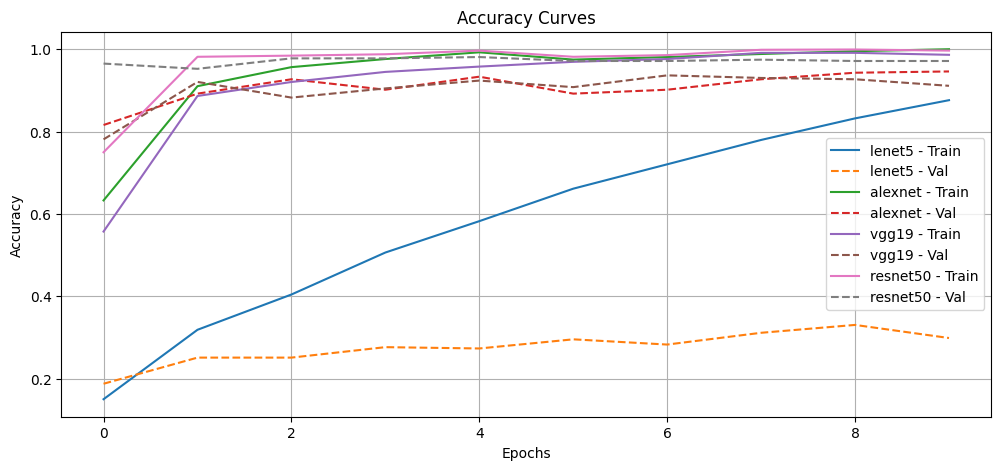

In [36]:
train_logs = {
    'lenet5': {
        'train_loss': [2.8977, 2.5945, 2.4089, 2.2214, 2.0561, 1.8820, 1.7290, 1.5620, 1.3976, 1.2421],
        'val_loss':   [2.7918, 2.6916, 2.6381, 2.5819, 2.5714, 2.5356, 2.5527, 2.4967, 2.4745, 2.4923],
        'train_acc':  [0.1497, 0.3184, 0.4041, 0.5061, 0.5823, 0.6612, 0.7204, 0.7796, 0.8320, 0.8762],
        'val_acc':    [0.1873, 0.2508, 0.2508, 0.2762, 0.2730, 0.2952, 0.2825, 0.3111, 0.3302, 0.2984]
    },
    'alexnet': {
        'train_loss': [1.2039, 0.2810, 0.1275, 0.0669, 0.0292, 0.0694, 0.0544, 0.0428, 0.0172, 0.0042],
        'val_loss':   [0.4663, 0.3161, 0.2310, 0.2759, 0.2024, 0.3562, 0.3207, 0.2249, 0.2089, 0.1733],
        'train_acc':  [0.6327, 0.9102, 0.9565, 0.9762, 0.9925, 0.9748, 0.9810, 0.9884, 0.9952, 1.0000],
        'val_acc':    [0.8159, 0.8921, 0.9270, 0.9016, 0.9333, 0.8921, 0.9016, 0.9270, 0.9429, 0.9460]
    },
    'vgg19': {
        'train_loss': [1.4493, 0.3484, 0.2228, 0.1762, 0.1447, 0.1027, 0.0819, 0.0395, 0.0329, 0.0471],
        'val_loss':   [0.6780, 0.2657, 0.3813, 0.2825, 0.2847, 0.3207, 0.2664, 0.2259, 0.3193, 0.3236],
        'train_acc':  [0.5571, 0.8864, 0.9204, 0.9449, 0.9578, 0.9694, 0.9762, 0.9912, 0.9912, 0.9864],
        'val_acc':    [0.7810, 0.9206, 0.8825, 0.9048, 0.9238, 0.9079, 0.9365, 0.9302, 0.9270, 0.9111]
    },
    'resnet50': {
        'train_loss': [1.1638, 0.1185, 0.0769, 0.0602, 0.0266, 0.0599, 0.0545, 0.0187, 0.0106, 0.0169],
        'val_loss':   [0.1773, 0.1427, 0.0912, 0.1064, 0.0950, 0.1003, 0.0675, 0.0708, 0.0683, 0.0624],
        'train_acc':  [0.7497, 0.9816, 0.9844, 0.9878, 0.9966, 0.9816, 0.9857, 0.9986, 0.9993, 0.9966],
        'val_acc':    [0.9651, 0.9524, 0.9778, 0.9778, 0.9810, 0.9714, 0.9714, 0.9746, 0.9714, 0.9714]
    }
}

plot_training_curves(train_logs)
